In [1]:
%matplotlib inline

In [2]:
import numpy as np
from math import inf
import matplotlib.pyplot as plt
from astrotog import transient_obs_dist as tod
import seaborn
# Import a cosmology, comment out if you want to define your own per the
# astropy cosmology class
from astropy.cosmology import Planck15 as cosmo

In [3]:
# Imports from package
import os
import re
import numpy as np
import sncosmo
from scipy.integrate import simps
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import opsimsummary as oss
import seaborn as sns
# font = {'size': 14}
# matplotlib.rc('font', **font)
sns.set_style('whitegrid')  # I personally like this style.
sns.set_context('talk')  # Easy to change context from `talk`, `notebook`, `poster`, `paper`. though further fine tuning is human.

In [4]:
# Define directory for locations of SEDS, references, throughputs
paths = {}
paths['seds'] = '/Users/cnsetzer/Documents/LSST/astrotog/sedb/rosswog/NSNS/winds'
paths['survey'] = '/Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db'
paths['throughputs'] = '/Users/cnsetzer/Documents/LSST/astrotog/throughputs'
paths['references'] = '/Users/cnsetzer/Documents/LSST/astrotog/throughputs/references'
# Relevant fields in the survey database
fields = ['fieldID', 'fieldRA', 'fieldDec', 'filter', 'expMJD', 'fiveSigmaDepth']
# Flag for the survey database retreival to only get a subset of the whole.
db_flag = 'all'
# Parameter prior for generating the transient KNe distribution
param_priors = {'zmin': 0.0, 'zmax': 0.22, 'z_bin_size': 0.02, 'rate': 1000.0,
                'cosmology': cosmo, 'kappa_min': 1, 'kappa_max': 10,
                'm_ej_min': 0.01, 'm_ej_max': 0.2, 'v_ej_min': 0.01, 'v_ej_max': 0.5}
instrument_params = {'Instrument': 'lsst', 'FOV_rad': np.deg2rad(1.75), 'Mag_Sys': 'ab'}
# Different selections cuts and corresponding limits
Cuts = {'SNR': {'upper': inf, 'lower': 5, 'limit': 1}}
# Flag for SED generation to just cycle through SEDs in the database
gen_flag = 'cycle'

In [5]:
# Initialize the figure number for iterative, functional plotting
fig_num = 1
# Setup the basic running structure
print(' ')
obs_database = tod.Get_ObsStratDB_Summary(paths['survey'], db_flag)
print(' Done reading in observation databse: {}'.format(paths['survey']))
print('\n Getting survey paramters...')
survey_params = tod.Get_Survey_Params(obs_database)
print(' Done retreiving survey paramters.')

 
 Using OpSimOutput tool to get the database of simulated survey observations.
 reading from database sqlite:////Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (54)
 Done reading in observation databse: /Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db

 Getting survey paramters...
 Done retreiving survey paramters.


In [6]:
# Generate the all mock KNe SEDs
print('\n Generating mock KNe sources...')
SEDs = tod.Gen_SED_dist(paths['seds'], survey_params, param_priors, gen_flag)
print(' Done generating mock KNe sources.')
print(' Getting the LSST throughputs and computing the reference fluxes...')
instrument_params = tod.Get_Throughputs(instrument_params, paths)
instrument_params = tod.Get_Reference_Flux(instrument_params, paths)
print(' Done computing instrument parameters.')


 Generating mock KNe sources...
 The number of mock SEDs being genereated is 13018
 The number of SEDs in Database is 23
 Done generating mock KNe sources.
 Getting the LSST throughputs and computing the reference fluxes...
 Done computing instrument parameters.


In [7]:
# Apply observation to all mock SEDs
print('\n Applying simulated observations to mock sources...')
All_Source_Observations = tod.Gen_Observations(SEDs, obs_database, instrument_params)
print(' Done generating simulated observations of mock sources.')


 Applying simulated observations to mock sources...
 Done generating simulated observations of mock sources.


In [8]:
# Add quality of observation information, currently just SNR
All_Source_Observations = tod.Assign_SNR(All_Source_Observations)
# Using this quality assignment and predefined selection cut criteria determine
# 'detections'
All_Source_Observations, Detections, n_detect, efficiency = tod.Get_Detections(All_Source_Observations, Cuts)
print('\n The number of detected KNe is {2} for a {0} cut of {1}.\n This is an efficiency of {3:.3f}%'
      .format('SNR', Cuts['SNR']['lower'], n_detect, 100*efficiency))
print('The number of mock sources is {0}, and the number of observed sources is \
        {1}'.format(len(SEDs.keys()), len(Detections.keys())))


 The number of detected KNe is 210 for a SNR cut of 5.
 This is an efficiency of 1.613%
The number of mock sources is 13018, and the number of observed sources is         210


The redshift range of all sources is 0.0111 to 0.2200.
The redshift range of the detected sources is 0.0175 to 0.1665.


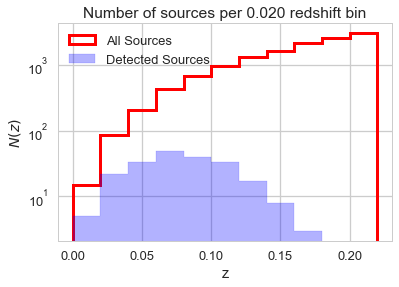

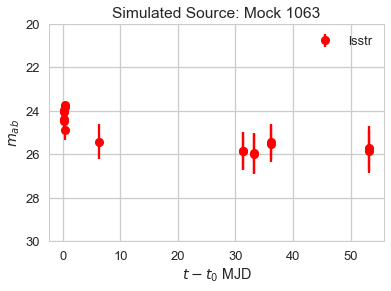

In [9]:
# Plot histogram of detected vs genereated mock KNe
N_z_fig, fig_num = tod.Get_N_z(SEDs, Detections, param_priors, fig_num)
# Plot the lightcurve results
Lightcurve_fig, fig_num = tod.Plot_Observations(Detections, fig_num)
# For the first run show only one plot
Lightcurve_fig.savefig('Max_LC.pdf', bbox_inches='tight')
N_z_fig.savefig('N_z.pdf', bbox_inches='tight')
plt.show()

In [10]:
Observations = deepcopy(Detections)

obs_key = 'observations'
source_list = Observations.keys()

# Plot max lc for talk
max_lc_p = 0
for key in source_list:
    band_keys = Observations[key][obs_key].keys()
    for i, band in enumerate(band_keys):
        num_p_lc = len(Observations[key][obs_key][band]['times'])
        if num_p_lc > max_lc_p:
            max_lc_p = num_p_lc
            max_band = band
            max_source_key = key

In [11]:
model_times = np.linspace(0,45,100)
plot_model_mags = Observations[max_source_key]['model'].bandmag('lssti','AB',model_times)
model_times

/Users/cnsetzer/miniconda3/envs/py3_allpurp/lib/python3.6/site-packages/sncosmo/models.py:187: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


array([  0.        ,   0.45454545,   0.90909091,   1.36363636,
         1.81818182,   2.27272727,   2.72727273,   3.18181818,
         3.63636364,   4.09090909,   4.54545455,   5.        ,
         5.45454545,   5.90909091,   6.36363636,   6.81818182,
         7.27272727,   7.72727273,   8.18181818,   8.63636364,
         9.09090909,   9.54545455,  10.        ,  10.45454545,
        10.90909091,  11.36363636,  11.81818182,  12.27272727,
        12.72727273,  13.18181818,  13.63636364,  14.09090909,
        14.54545455,  15.        ,  15.45454545,  15.90909091,
        16.36363636,  16.81818182,  17.27272727,  17.72727273,
        18.18181818,  18.63636364,  19.09090909,  19.54545455,
        20.        ,  20.45454545,  20.90909091,  21.36363636,
        21.81818182,  22.27272727,  22.72727273,  23.18181818,
        23.63636364,  24.09090909,  24.54545455,  25.        ,
        25.45454545,  25.90909091,  26.36363636,  26.81818182,
        27.27272727,  27.72727273,  28.18181818,  28.63

KeyError: 'Mock 281'

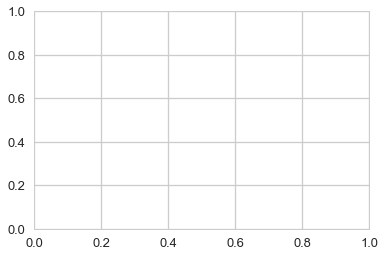

In [12]:
#max_source_key = 'Mock 281'
#max_band = 'lsstr'
f = plt.figure(fig_num)
axes = f.add_subplot(1, 1, 1)
t_0 = Observations[max_source_key]['parameters']['min_MJD']
times = deepcopy(Observations[max_source_key][obs_key][max_band]['times'])
times = times - t_0
mags = deepcopy(Observations[max_source_key][obs_key][max_band]['magnitudes'])
errs = deepcopy(Observations[max_source_key][obs_key][max_band]['mag_errors'])
axes.errorbar(x=times, y=mags, yerr=errs, fmt='ro')
axes.legend(['{0}'.format(max_band)])
axes.set(xlabel=r'$t - t_{0}$ MJD', ylabel=r'$m_{ab}$')
axes.set_ylim(bottom=27.0, top=22.0)
axes.set_title('Simulated Source: {}'.format(max_source_key))
f.savefig('test1.pdf', bbox_inches='tight')